## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

Импортируем библиотекиу pandas для обработки и анализа табличных данных, а также библиотеку pymystem3 для проведения лемматизации

In [69]:
import pandas as pd
from pymystem3 import Mystem
m = Mystem()

In [70]:
from google.colab import files
uploaded = files.upload()

Saving credit_scoring_eng.csv to credit_scoring_eng.csv


Читаем и выводим на экран csv-файл

In [71]:
df = pd.read_csv('credit_scoring_eng.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,19351.000000
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,26787.568355
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,16475.450632
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,3306.762000
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,16488.504500
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,23202.870000
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,32549.611000
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,362496.645000


In [72]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,secondary education,1,civil partnership,1,F,business,0,35966.698,housing transactions
21521,0,343937.404131,67,secondary education,1,married,0,F,retiree,0,24959.969,purchase of a car
21522,1,-2113.346888,38,secondary education,1,civil partnership,1,M,employee,1,14347.610,property
21523,3,-3112.481705,38,secondary education,1,married,0,M,employee,1,39054.888,buying my own car


### Вывод

Файл открыли и изучли - он содержит таблицу, состоящую 21525 строк и 12 колонок:
- не все данные присутствуют в колонках:
    - `days_employed`
    - `total_income`
    
- колонки с некорректным типом данных:
    - `days_employed`
    - `total_income`
- явные ошибки в данных в колонках children, days_employed;


### Шаг 2. Предобработка данных

### Изменение названий столбцов и обработка пропусков

#### Изменение названий столбцов

Выводим текущие названия столбцов

In [73]:
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

gender – Пол бинарная переменная мужской или женский;

family_status – Семейное положение словами,
family_status_id - Семейное положение айди, married - 0, civil partnership - 1,  widow / widower - 2, divorced - 3, unmarried - 4;

children – Количество детей;

education – Уровень образования словами,
education_id - Уровень образования айди, bachelor's degree - 0 (степень бакалавра), secondary education - 1 (среднее образование), some college - 2 (какой-нибудь колледж), primary education - 3 (начальное образование), graduate degree - 4 (степень магистра);

income_type – Вид занятости: employee, business, retiree (пенсионер), civil servant (госслужащий), unemployed (безработный);

total_income – Доход заемщика;

dob_years – Возраст заемщика;

days_employed – Дни занятости заемщика;

purpose – Цель взятия кредита;

debt – Долг бинарная пермененная есть долг (1) или нет долга (0).

Корректируем названия столбцов

In [74]:
df.rename(columns={'debt': 'debt', 'dob_years':'age', 'days_employed':'days_employed',
                   'gender':'gender', 'children':'children_number','family_status':'family_status', 'education':'education', 'education_id':'education_id',
                   'income_type':'income_type', 'total_income':'total_income', 'purpose':'purpose'}, inplace=True)
df.columns

Index(['children_number', 'days_employed', 'age', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

In [75]:
df

,children_number,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,secondary education,1,civil partnership,1,F,business,0,35966.698,housing transactions
21521,0,343937.404131,67,secondary education,1,married,0,F,retiree,0,24959.969,purchase of a car
21522,1,-2113.346888,38,secondary education,1,civil partnership,1,M,employee,1,14347.610,property
21523,3,-3112.481705,38,secondary education,1,married,0,M,employee,1,39054.888,buying my own car


#### Обработка пропусков

##### Считаем доли пропусков

In [76]:
df.isna().mean()

children_number     0.000000
days_employed       0.100999
age                 0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

##### Заполняем пропуски

In [77]:
df['days_employed']=df['days_employed'].fillna(0)
# расчет медианного значения по `income_type` и сохранение его в `income_type_median`
income_type_median=df.groupby('income_type')['total_income'].median()
# подставновка рассчитанного медианного значения в пропущенные ячейки
for income_type in income_type_median.index:
    df.loc[(df['total_income'].isna()) & (df['income_type'] == income_type), 'total_income'] = income_type_median.loc[income_type]
    

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children_number   21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   age               21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [79]:
# Замена типа данных
for col in ['days_employed', 'total_income']:
    df[col]=df[col].astype('int')
df.dtypes

children_number      int64
days_employed        int64
age                  int64
education           object
education_id         int64
family_status       object
family_status_id     int64
gender              object
income_type         object
debt                 int64
total_income         int64
purpose             object
dtype: object

##### Вывод

Пропуски в таблице были заменены средними значениями

##### Обработка дубликатов

In [80]:
# В колонках "education" и "family_status" попадаются разные варианты написания (и использованием заглавных букв и без них)
# Приведем все к нижнему регистру
for col in df.columns:
    try:
        df[col] = df[col].str.lower()
    except AttributeError:
        pass

In [81]:
# Посчитаем количество дубликатов
print('Дубликатов в таблице: ', df.duplicated().sum())

Дубликатов в таблице:  71


In [82]:
# Удалим дубликаты и вновь проверим количество дубликатов
df=df.drop_duplicates()
print('Дубликатов в таблице: ', df.duplicated().sum())

Дубликатов в таблице:  0


### Вывод

Перевели все буквы в нижний регистр, удалили дубликаты из таблицы.

##### Корректировка значений

In [83]:
df['children_number'] = df['children_number'].replace({-1 : 1, 20 : 2})
df.children_number.value_counts()

<ipython-input-83-482972612ef5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['children_number'] = df['children_number'].replace({-1 : 1, 20 : 2})


0    14091
1     4855
2     2128
3      330
4       41
5        9
Name: children_number, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


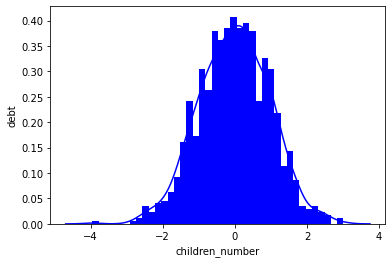

In [65]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
 

df =stats.norm(scale=1, loc=0).rvs(1000)
 

ax = sns.distplot(df,
                  bins=40,
                  kde=True,
                  color='blue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='children_number', ylabel='debt')
 
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


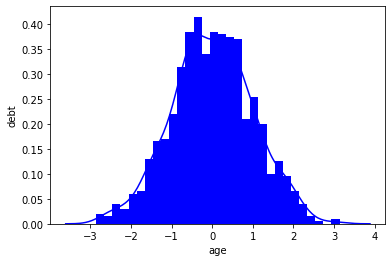

In [66]:
df =stats.norm(scale=1, loc=0).rvs(1000)
 

ax = sns.distplot(df,
                  bins=30,
                  kde=True,
                  color='blue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='age', ylabel='debt')
 
plt.show()

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [84]:
children_debt=df.pivot_table(index='children_number',values='debt',aggfunc=['count','sum'])
children_debt['%']=round((children_debt[('sum', 'debt')]/children_debt[('count', 'debt')])*100,2)
children_debt.columns = ['Общее количество заемщиков','Количество просрочников','%']
children_debt

,Общее количество заемщиков,Количество просрочников,%
children_number,,,
0,14091,1063,7.54
1,4855,445,9.17
2,2128,202,9.49
3,330,27,8.18
4,41,4,9.76
5,9,0,0.00


### Вывод

Среди заемщиков с детьми доля тех, кто имеет задолжности на 1-2% выше, чем у тех, у кого 0 детей.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [85]:
family_status_debt=df.pivot_table(index='family_status', values='debt',aggfunc=['count','sum'])
family_status_debt['%']=round((family_status_debt[('sum', 'debt')]/family_status_debt[('count', 'debt')])*100,2)
family_status_debt.columns = ['Общее количество заемщиков','Количество просрочников','%']
family_status_debt.sort_values(by = '%', ascending = False)

,Общее количество заемщиков,Количество просрочников,%
family_status,,,
unmarried,2810,274,9.75
civil partnership,4151,388,9.35
married,12339,931,7.55
divorced,1195,85,7.11
widow / widower,959,63,6.57


### Вывод

Неженатые и в гражданском браке допускают больше всего просрочек по кредитам 
(9.75 и 9.35 %), затем идут женатые и разведенные (7.55 и 7.11 %), меньше всего допускают просрочек по кредиту в процентах от общего числа по категории вдовы/вдовцы (6.57 %)

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [86]:
import numpy as np
total_income_debt=pd.DataFrame(df, columns=['total_income', 'debt'])
total_income_debt['income_groups'] = pd.cut(total_income_debt['total_income'],[0,3000,5000,10000,50000,np.inf],labels=["до 3 тыс.","3-5 тыс.", "5-10 тыс.","10-50 тыс.","свыше 50 тыс."])
total_income_debt=total_income_debt.groupby('income_groups')['debt'].agg(['count','sum'])
total_income_debt['%']=round((total_income_debt[('sum')]/total_income_debt[('count')])*100,2)
total_income_debt.columns = ['Общее количество заемщиков','Количество просрочников','%']
total_income_debt

,Общее количество заемщиков,Количество просрочников,%
income_groups,,,
до 3 тыс.,0,0,NaN
3-5 тыс.,26,2,7.69
5-10 тыс.,901,56,6.22
10-50 тыс.,19206,1591,8.28
свыше 50 тыс.,1321,92,6.96


### Вывод

Людей с доходом от 0 до 5тыс. мало, ничего нельзя сказать. Заемщики с доходом от 10 до 50 тыс. чаще допускают просрочки по кредиту, чем люди с доходом в 5-10 тыс.

- Как образование влияет на возврат кредита в срок?




In [87]:
loan_purpose_debt=pd.DataFrame(df, columns=['education', 'debt'])
loan_purpose_debt_gr=loan_purpose_debt.groupby('education')['debt'].agg(['count','sum'])
loan_purpose_debt_gr['%']=round((loan_purpose_debt_gr[('sum')]/loan_purpose_debt_gr[('count')])*100,2)
loan_purpose_debt_gr.columns = ['Общее количество заемщиков','Количество просрочников','%']
loan_purpose_debt_gr.sort_values(by='%',ascending = False)

,Общее количество заемщиков,Количество просрочников,%
education,,,
primary education,282,31,10.99
some college,744,68,9.14
secondary education,15172,1364,8.99
bachelor's degree,5250,278,5.30
graduate degree,6,0,0.00


### Вывод

Люди с высшим образованием чаще возвращают кредит вовремя. Выше всего процент просрочек у людей с начальным образованием.

In [89]:
from google.colab import files
df.to_csv("zpz_zaemi.csv")
files.download("zpz_zaemi.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
from google.colab import files
total_income_debt.to_csv("total_income_debt.csv")
files.download("total_income_debt.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
total_income_debt2=pd.DataFrame(df, columns=['total_income', 'debt'])
total_income_debt2['income_groups'] = pd.cut(total_income_debt2['total_income'],[0,5000,10000,50000,np.inf],labels=["до 5 тыс.", "5-10 тыс.","10-50 тыс.","свыше 50 тыс."])
total_income_debt2=total_income_debt2.groupby('income_groups')['debt'].agg(['count','sum'])
total_income_debt2['%']=round((total_income_debt2[('sum')]/total_income_debt2[('count')])*100,2)
total_income_debt2.columns = ['Общее количество заемщиков','Количество просрочников','%']
total_income_debt2

,Общее количество заемщиков,Количество просрочников,%
income_groups,,,
до 5 тыс.,26,2,7.69
5-10 тыс.,901,56,6.22
10-50 тыс.,19206,1591,8.28
свыше 50 тыс.,1321,92,6.96


In [95]:
from google.colab import files
total_income_debt2.to_csv("total_income_debtnew.csv")
files.download("total_income_debtnew.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>